In [1]:
import os.path
import re

import pandas as pd
import numpy as np

from scipy.cluster.vq import kmeans, kmeans2
from sklearn.cluster import KMeans

import matplotlib as plt
import seaborn as sns

Load the data and preprocess it.

In [2]:
FILEPATH = os.path.abspath("../data/2023-03-25_22hr_29min_ptwr_data.tsv")
df = pd.read_csv(FILEPATH, sep="\t")

MAKE = "make"
MODEL = "model"
SPECS = "specs"

CLEAN_MAKE = re.compile(r"((/make/)|(\-power\-to\-weight\-ratio\-stats))")
CLEAN_MODEL = re.compile(r"(/model/)")
CLEAN_SPECS = re.compile(r"(\\t|\\n)")

df[MAKE] = df[MAKE].apply(lambda x: CLEAN_MAKE.sub("", x))
df[MODEL] = df[MODEL].apply(lambda x: CLEAN_MODEL.sub("", x))
df[SPECS] = df[SPECS].apply(lambda x: CLEAN_SPECS.sub("", x))

SEPARATOR = ":"
SPECS1 = "specs1"
df[SPECS1] = df[SPECS].apply(lambda x: float(x.split(SEPARATOR)[-1]))
df[SPECS] = df[SPECS].apply(lambda x: SEPARATOR.join((x.split(SEPARATOR)[:-1])))

print(df.describe())
print(df.head())

             specs1
count  43219.000000
mean       0.064918
std        0.029648
min        0.017000
25%        0.050000
50%        0.059000
75%        0.070000
max        0.636000
    make     model                      specs  specs1
0  acura  acura-cl         1997 Acura CL 2.2    0.047
1  acura  acura-cl         1998 Acura CL 2.3    0.049
2  acura  acura-cl  1998 Acura CL 2.3 Premium   0.049
3  acura  acura-cl         1999 Acura CL 2.3    0.049
4  acura  acura-cl         1997 Acura CL 3.0    0.062


# Introduction

I am going to rely upon classifiers which have discriminants calculated from the mean of the training data set and also what is calculated using the scipy library's kmeans2 clustering algorithm. I will use both of these techniques to model power-to-weight ratios per model year and assess the effectiveness when the data is partitioned in this way.

In [3]:
K = 2
HIGH = 1
LOW = 0
NUM_FOLDS = 7
NUM_ITERATIONS = 200

MODEL_YEAR = "model_year"
MATCH_MODEL_YEAR = re.compile(r"[0-9]{4}")
df[MODEL_YEAR] = df[SPECS].apply(lambda x: MATCH_MODEL_YEAR.match(x).group(0))
MODEL_YEARS = df[MODEL_YEAR]
print(np.sum(MODEL_YEARS == None))  # check if regex matches every row
MODEL_YEARS = MODEL_YEARS.unique()
print(MODEL_YEARS)

# df = df.sample(frac=1)

0
['1997' '1998' '1999' '2001' '2002' '2003' '2013' '2014' '2015' '2016'
 '2017' '2018' '2019' '2020' '2021' '2022' '1992' '2000' '1994' '1995'
 '1996' '1993' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2023' '1991' '1987' '1988' '1989' '1990' '1986' '1978']


# Attempt 1 Classification within Model Year: Mean Discriminator

In [4]:
def mean_inference(df, mean):
    result = df.apply(lambda x: HIGH if x > mean else LOW)
    return result

<Axes: xlabel='Accuracy', ylabel='Std'>

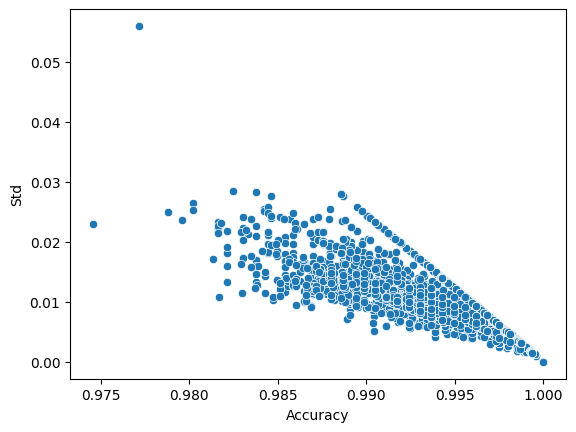

In [5]:
metrics_by_model_year = {}
for i in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    for year in MODEL_YEARS:
        df2 = df[df[MODEL_YEAR] == year]
        LENGTH = len(df2)
        if LENGTH < NUM_FOLDS:
            continue
        mean_reference = mean_inference(df2[SPECS1], np.mean(df2[SPECS1]))

        metrics = {}
        for i in range(NUM_FOLDS):
            test = df2.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
            train_values = df2[~df2.index.isin(test.index)][SPECS1]

            mean = np.mean(train_values)
            test_inferred = mean_inference(test[SPECS1], mean)
            mean_reference_test_view = mean_reference.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]

            # positive class is HIGH
            tp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == HIGH])
            tn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == LOW])
            fp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == HIGH])
            fn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == LOW])

            metrics[str(i)] = [tp, tn, fp, fn]
        if year not in metrics_by_model_year:
            metrics_by_model_year[year] = []
        metrics_by_model_year[year].append(metrics)

metric_data_for_plot = []
for year, metrics in metrics_by_model_year.items():
    for metric in metrics:
        accuracies = []
        for key, val in metric.items():
            accuracies.append((val[0]+val[1])/np.sum(val))
        mean_accuracy_overall = np.mean(accuracies)
        mean_std_overall = np.std(accuracies)
        metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

# Attempt 2 Classification within Model Year: K-Means Clustering Discriminator

### Scipy kmeans2

In [6]:
def kmeans_inference(df, high_centroid, low_centroid):
    result = df.apply(lambda x: HIGH if np.abs(high_centroid-x) < np.abs(low_centroid-x) else LOW)
    return result

/Users/alexanderdeforge/Documents/projects/repos/vehicles-power-to-weight/.venv/lib/python3.9/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


<Axes: xlabel='Accuracy', ylabel='Std'>

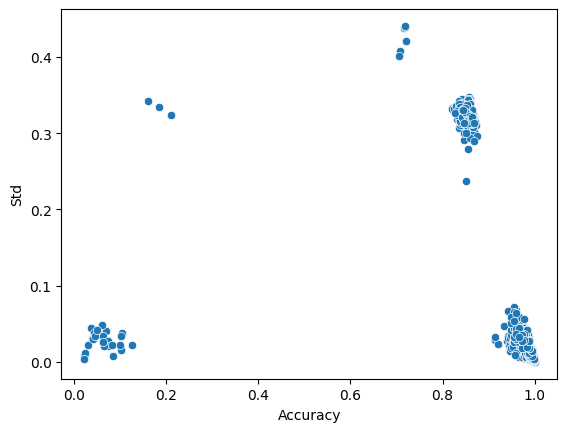

In [7]:
metrics_by_model_year = {}
for i in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    for year in MODEL_YEARS:
        df2 = df[df[MODEL_YEAR] == year]
        LENGTH = len(df2)
        if LENGTH < NUM_FOLDS:
            continue
        kmeans2_centroids, distortion2 = kmeans2(df2[SPECS1], K)
        high_kmeans2_centroid = kmeans2_centroids[1] if kmeans2_centroids[1] > kmeans2_centroids[0] else kmeans2_centroids[0]
        low_kmeans2_centroid = kmeans2_centroids[1] if kmeans2_centroids[1] < kmeans2_centroids[0] else kmeans2_centroids[0]
        kmeans2_reference = kmeans_inference(df2[SPECS1], high_kmeans2_centroid, low_kmeans2_centroid)

        metrics = {}
        for i in range(NUM_FOLDS):
            test = df2.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
            train_values = df2[~df2.index.isin(test.index)][SPECS1]

            centroids, distortion = kmeans2(train_values, K)
            high_centroid = centroids[1] if centroids[1] > centroids[0] else centroids[0]
            low_centroid = centroids[1] if centroids[1] < centroids[0] else centroids[0]
            test_inferred = kmeans_inference(test[SPECS1], high_centroid, low_centroid)
            kmeans2_reference_test_view = kmeans2_reference.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]

            # positive class is HIGH
            tp = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x == y and x == HIGH])
            tn = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x == y and x == LOW])
            fp = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x != y and x == HIGH])
            fn = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x != y and x == LOW])

            metrics[str(i)] = [tp, tn, fp, fn]
        if year not in metrics_by_model_year:
            metrics_by_model_year[year] = []
        metrics_by_model_year[year].append(metrics)

metric_data_for_plot = []
for year, metrics in metrics_by_model_year.items():
    for metric in metrics:
        accuracies = []
        for key, val in metric.items():
            accuracies.append((val[0]+val[1])/np.sum(val))
        mean_accuracy_overall = np.mean(accuracies)
        mean_std_overall = np.std(accuracies)
        metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

# Discussion: Classification within Model Year Attempts 1-2

In the charts above, we are looking for both high accuracy and low standard deviation as much as possible per each model year. Each data point is the average k-fold accuracy and standard deviation for the power-to-weight ratios in a given model year. It seems that the mean discriminator performed most consistently.

# Attempt 1 Classification against Global: Mean Discriminator

<Axes: xlabel='Accuracy', ylabel='Std'>

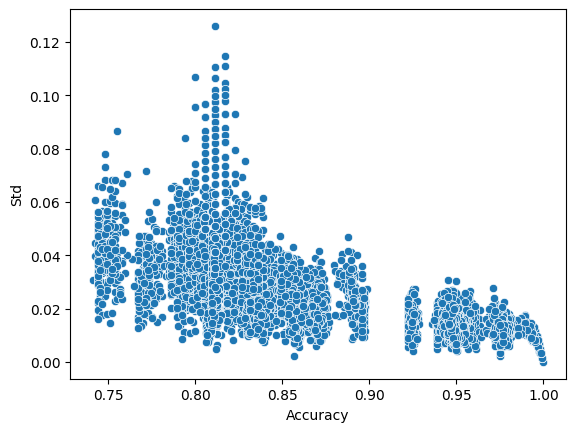

In [8]:
metrics_by_model_year = {}
for i in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    mean_reference = mean_inference(df[SPECS1], np.mean(df[SPECS1]))
    for year in MODEL_YEARS:
        df2 = df[df[MODEL_YEAR] == year]
        LENGTH = len(df2)
        if LENGTH < NUM_FOLDS:
            continue

        metrics = {}
        for i in range(NUM_FOLDS):
            test = df2.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
            train_values = df2[~df2.index.isin(test.index)][SPECS1]

            mean = np.mean(train_values)
            test_inferred = mean_inference(test[SPECS1], mean)
            mean_reference_test_view = mean_reference[mean_reference.index.isin(test.index.values)]

            # positive class is HIGH
            tp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == HIGH])
            tn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == LOW])
            fp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == HIGH])
            fn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == LOW])

            metrics[str(i)] = [tp, tn, fp, fn]
        if year not in metrics_by_model_year:
            metrics_by_model_year[year] = []
        metrics_by_model_year[year].append(metrics)

metric_data_for_plot = []
for year, metrics in metrics_by_model_year.items():
    for metric in metrics:
        accuracies = []
        for key, val in metric.items():
            accuracies.append((val[0]+val[1])/np.sum(val))
        mean_accuracy_overall = np.mean(accuracies)
        mean_std_overall = np.std(accuracies)
        metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

# Attempt 2 Classification against Global: K-Means Clustering Discriminator

### Scipy kmeans2

/Users/alexanderdeforge/Documents/projects/repos/vehicles-power-to-weight/.venv/lib/python3.9/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


<Axes: xlabel='Accuracy', ylabel='Std'>

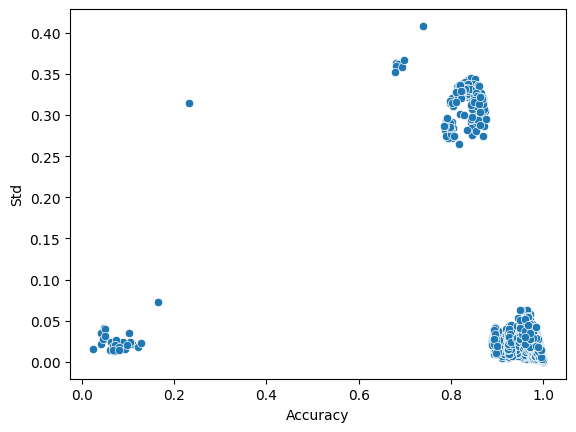

In [9]:
metrics_by_model_year = {}
for i in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    kmeans2_centroids, distortion2 = kmeans2(df[SPECS1], K)
    high_kmeans2_centroid = kmeans2_centroids[1] if kmeans2_centroids[1] > kmeans2_centroids[0] else kmeans2_centroids[0]
    low_kmeans2_centroid = kmeans2_centroids[1] if kmeans2_centroids[1] < kmeans2_centroids[0] else kmeans2_centroids[0]
    kmeans2_reference = kmeans_inference(df[SPECS1], high_kmeans2_centroid, low_kmeans2_centroid)
    for year in MODEL_YEARS:
        df2 = df[df[MODEL_YEAR] == year]
        LENGTH = len(df2)
        if LENGTH < NUM_FOLDS:
            continue

        metrics = {}
        for i in range(NUM_FOLDS):
            test = df2.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
            train_values = df2[~df2.index.isin(test.index)][SPECS1]

            centroids, distortion = kmeans2(train_values, K)
            high_centroid = centroids[1] if centroids[1] > centroids[0] else centroids[0]
            low_centroid = centroids[1] if centroids[1] < centroids[0] else centroids[0]
            test_inferred = kmeans_inference(test[SPECS1], high_centroid, low_centroid)
            kmeans2_reference_test_view = kmeans2_reference.iloc[kmeans2_reference.index.isin(test.index.values)]

            # positive class is HIGH
            tp = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x == y and x == HIGH])
            tn = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x == y and x == LOW])
            fp = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x != y and x == HIGH])
            fn = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x != y and x == LOW])

            metrics[str(i)] = [tp, tn, fp, fn]
        if year not in metrics_by_model_year:
            metrics_by_model_year[year] = []
        metrics_by_model_year[year].append(metrics)

metric_data_for_plot = []
for year, metrics in metrics_by_model_year.items():
    for metric in metrics:
        accuracies = []
        for key, val in metric.items():
            accuracies.append((val[0]+val[1])/np.sum(val))
        mean_accuracy_overall = np.mean(accuracies)
        mean_std_overall = np.std(accuracies)
        metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

# Discussion: Classification against Global Attempts 1-2

Similar results to the discussion on classification within model year. The performance seems to be a little better within model year than against a global dataset.

# Answer for Objective 2

The mean discriminator should be used for this data and this task. The ultimate goal, Objective 3, is to be able to predict high/low power-to-weight ratio as if this data were obtained in a realistic fashion year after year. More on that in the next notebook.